#Storage and File Structure

In [ ]:
import sqlite3

# Connect to an in-memory SQLite database
conn = sqlite3.connect(':memory:')

#Organizing Records in a File

#Fixed-Length Records

In [ ]:
# Create a table with fixed-length records
conn.execute('''CREATE TABLE IF NOT EXISTS FixedLengthRecords (
                    id INTEGER PRIMARY KEY,
                    name TEXT,
                    age INTEGER
                )''')

# Insert data into the table
conn.execute("INSERT INTO FixedLengthRecords (name, age) VALUES ('John', 30)")
conn.execute("INSERT INTO FixedLengthRecords (name, age) VALUES ('Alice', 25)")

#Variable-Length Records

In [ ]:
# Create a table with variable-length records
conn.execute('''CREATE TABLE IF NOT EXISTS VariableLengthRecords (
                    id INTEGER PRIMARY KEY,
                    message TEXT
                )''')

# Insert data into the table
conn.execute("INSERT INTO VariableLengthRecords (message) VALUES ('This is a short message')")
conn.execute("INSERT INTO VariableLengthRecords (message) VALUES ('This is a longer message with more characters')")

#Organization methods for basic files

#Heap Files

Heap files store records without any particular order.

In [ ]:
heap_file = []

# Inserting records into the heap file
heap_file.append({'id': 1, 'name': 'Alice', 'age': 25})
heap_file.append({'id': 2, 'name': 'John', 'age': 30})

In [ ]:
heap_file

[{'id': 1, 'name': 'Alice', 'age': 25}, {'id': 2, 'name': 'John', 'age': 30}]

#Sequential/Ordered Files

Sequential files store records in sorted order based on a specified key.

In [ ]:
# Define records
records = [
    {'id': 1, 'name': 'Alice', 'age': 25},
    {'id': 2, 'name': 'John', 'age': 30}
]

# Sort records based on name
sorted_records = sorted(records, key=lambda x: x['name'])
sorted_records

[{'id': 1, 'name': 'Alice', 'age': 25}, {'id': 2, 'name': 'John', 'age': 30}]

#Random/ Direct Access Files

Random access files allow direct access to any record based on its location or index.

In [ ]:
random_access_file = {
    1: {'name': 'Alice', 'age': 25},
    2: {'name': 'John', 'age': 30}
}

# Access record with id 1 directly
record_with_id_1 = random_access_file[1]
record_with_id_1

{'name': 'Alice', 'age': 25}

#Indexed Sequential Files

Indexed sequential files combine sequential organization with indexing for faster access.

In [ ]:
# Define records
records = [
    {'id': 1, 'name': 'Alice', 'age': 25},
    {'id': 2, 'name': 'John', 'age': 30}
]

# Create an index based on name
index = {record['name']: record for record in records}

# Access record with name 'Alice' directly
record_with_name_alice = index['Alice']
record_with_name_alice

{'id': 1, 'name': 'Alice', 'age': 25}

#Hash Files

Hash files use a hashing function to determine the location of records within the file.

In [ ]:
# Define records
records = {
    'Alice': {'id': 1, 'age': 25},
    'John': {'id': 2, 'age': 30}
}

# Access record with name 'Alice' directly
record_with_name_alice = records['Alice']

#B+ Trees

B+ trees are commonly used in database systems to store and retrieve data efficiently.

In [ ]:
class TreeNode:
    def __init__(self, leaf=False):
        self.keys = []
        self.children = []
        self.leaf = leaf

class BPlusTree:
    def __init__(self, order):
        self.root = TreeNode(leaf=True)
        self.order = order

    def insert(self, key, value):
        if key in self.root.keys:
            raise ValueError("Duplicate keys are not allowed")

        if len(self.root.keys) == (2 * self.order) - 1:
            new_root = TreeNode()
            new_root.children.append(self.root)
            self._split(new_root, 0)
            self.root = new_root

        self._insert_non_full(self.root, key, value)

    def _insert_non_full(self, node, key, value):
        index = len(node.keys) - 1
        if node.leaf:
            node.keys.append(None)
            while index >= 0 and key < node.keys[index]:
                node.keys[index + 1] = node.keys[index]
                index -= 1
            node.keys[index + 1] = key
        else:
            while index >= 0 and key < node.keys[index]:
                index -= 1
            index += 1
            if len(node.children[index].keys) == (2 * self.order) - 1:
                self._split(node, index)
                if key > node.keys[index]:
                    index += 1
            self._insert_non_full(node.children[index], key, value)

    def _split(self, parent, index):
        order = self.order
        node = parent.children[index]
        new_node = TreeNode(leaf=node.leaf)

        parent.keys.insert(index, node.keys[order - 1])
        parent.children.insert(index + 1, new_node)
        new_node.keys = node.keys[order:]
        node.keys = node.keys[:order - 1]

        if not node.leaf:
            new_node.children = node.children[order:]
            node.children = node.children[:order]

    def search(self, key):
        return self._search(self.root, key)

    def _search(self, node, key):
        index = 0
        while index < len(node.keys) and key > node.keys[index]:
            index += 1
        if index < len(node.keys) and key == node.keys[index]:
            return node, index
        elif node.leaf:
            return None, None
        else:
            return self._search(node.children[index], key)

    def __getitem__(self, key):
        node, index = self.search(key)
        if node and index is not None:
            return node.keys[index]
        raise KeyError("Key not found")

# Example usage:
tree = BPlusTree(order=3)
tree.insert(10, "Value for 10")
tree.insert(20, "Value for 20")
tree.insert(5, "Value for 5")

print(tree.search(10))
print(tree.search(20))
print(tree.search(5))

try:
    print(tree.search(15))
except KeyError as e:
    print(e)

(<__main__.TreeNode object at 0x7b6c5c22b250>, 1)
(<__main__.TreeNode object at 0x7b6c5c22b250>, 2)
(<__main__.TreeNode object at 0x7b6c5c22b250>, 0)
(None, None)


#Transactions, retreival and concurrency control

#Concurrency Control


In [ ]:
import sqlite3

# Connect to an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Enable autocommit mode
conn.isolation_level = None

# Create a table
conn.execute('''CREATE TABLE IF NOT EXISTS Employees (
                    id INTEGER PRIMARY KEY,
                    name TEXT,
                    age INTEGER
                )''')

# Insert data into the table
conn.execute("INSERT INTO Employees (name, age) VALUES ('Alice', 30)")
conn.execute("INSERT INTO Employees (name, age) VALUES ('Bob', 25)")

# Commit the transaction
conn.commit()

# Close the connection
conn.close()

#Deadlock Prevention

In [ ]:
import sqlite3

# Connect to an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Enable autocommit mode
conn.isolation_level = None

# Create a table
conn.execute('''CREATE TABLE IF NOT EXISTS Employees (
                    id INTEGER PRIMARY KEY,
                    name TEXT,
                    age INTEGER
                )''')

# Start a transaction
cursor = conn.cursor()
cursor.execute("BEGIN TRANSACTION")

# Insert data into the table
cursor.execute("INSERT INTO Employees (name, age) VALUES ('Alice', 30)")
cursor.execute("INSERT INTO Employees (name, age) VALUES ('Bob', 25)")

# Commit the transaction
cursor.execute("COMMIT")

#Database Recovery

In [ ]:
# SQLite provides mechanisms for database recovery, including journaling and WAL.
# Here's an example of enabling WAL mode for better recovery:

# Connect to an in-memory SQLite database with WAL mode
conn = sqlite3.connect(':memory:', isolation_level=None)
conn.execute("PRAGMA journal_mode = WAL")

# Create a table
conn.execute('''CREATE TABLE IF NOT EXISTS Products (
                    id INTEGER PRIMARY KEY,
                    name TEXT,
                    price REAL
                )''')

# Insert data into the table
conn.execute("INSERT INTO Products (name, price) VALUES ('Laptop', 999.99)")
conn.execute("INSERT INTO Products (name, price) VALUES ('Phone', 599.99)")

# Close the connection
conn.close()

#Information Retrieval - Searching and Retrieving Documents

In [ ]:
import sqlite3

# Connect to an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Create a table 'Documents'
conn.execute('''CREATE TABLE Documents (
                    id INTEGER PRIMARY KEY,
                    content TEXT
                )''')

# Define a function to search for documents containing specific keywords
def search_documents(keywords):
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM Documents WHERE content LIKE ?", ('%{}%'.format(keywords),))
    results = cursor.fetchall()
    return results

# Insert some example documents
documents = [
    "Machine learning is a subset of artificial intelligence.",
    "Data mining involves extracting patterns from large datasets.",
    "Natural language processing enables computers to understand human language."
]

for doc_id, content in enumerate(documents, 1):
    conn.execute("INSERT INTO Documents (id, content) VALUES (?, ?)", (doc_id, content))

# Example usage:
results = search_documents('machine learning')
for result in results:
    print(result)

# Close the connection
conn.close()

(1, 'Machine learning is a subset of artificial intelligence.')


#Document Retrieval

#Boolean Model

In [ ]:
import sqlite3

# Connect to an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Create a table 'Documents'
conn.execute('''CREATE TABLE Documents (
                    id INTEGER PRIMARY KEY,
                    content TEXT
                )''')

# Define a function to perform boolean retrieval
def boolean_retrieval(query):
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM Documents WHERE content LIKE ?", ('%' + query + '%',))
    results = cursor.fetchall()
    return results

# Insert some example documents
documents = [
    "Machine learning is a subset of artificial intelligence.",
    "Data mining involves extracting patterns from large datasets.",
    "Natural language processing enables computers to understand human language."
]

for doc_id, content in enumerate(documents, 1):
    conn.execute("INSERT INTO Documents (id, content) VALUES (?, ?)", (doc_id, content))

# Example usage:
results = boolean_retrieval('"machine learning" AND "data mining"')
for result in results:
    print(result)

# Close the connection
conn.close()


#Inverted Index

In [ ]:
import re
import sqlite3

# Connect to an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Create a table 'Documents'
conn.execute('''CREATE TABLE Documents (
                    id INTEGER PRIMARY KEY,
                    content TEXT
                )''')

# Insert some example documents
documents = [
    "Machine learning is a subset of artificial intelligence.",
    "Data mining involves extracting patterns from large datasets.",
    "Natural language processing enables computers to understand human language."
]

for doc_id, content in enumerate(documents, 1):
    conn.execute("INSERT INTO Documents (id, content) VALUES (?, ?)", (doc_id, content))

# Function to create an inverted index
def create_inverted_index(conn):
    inverted_index = {}
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM Documents")
    documents = cursor.fetchall()
    for doc in documents:
        words = re.findall(r'\w+', doc[1].lower())  # assuming content is in the second column
        for word in words:
            if word not in inverted_index:
                inverted_index[word] = set()
            inverted_index[word].add(doc[0])  # assuming id is in the first column
    return inverted_index

# Function to perform retrieval using the inverted index
def inverted_index_retrieval(query, inverted_index):
    words = re.findall(r'\b(?!and|or)\w+\b', query.lower())
    result = set(inverted_index[words[0]])
    for word in words[1:]:
        result = result.intersection(inverted_index[word])
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM Documents WHERE id IN ({seq})".format(seq=','.join(['?']*len(result))), tuple(result))
    results = cursor.fetchall()
    return results

# Example usage:
inverted_index = create_inverted_index(conn)
results = inverted_index_retrieval("machine learning AND data mining", inverted_index)
for result in results:
    print(result)

# Close the connection
conn.close()

#Multimedia Database
#Similarity Search Concepts
Similarity search in multimedia databases involves finding objects that are similar to a given query object. Concepts such as distance metrics (e.g., Euclidean distance, cosine similarity) and search algorithms (e.g., k-nearest neighbors, range queries) are essential.

In [ ]:
# Implement similarity search concepts
# Example: Compute cosine similarity between two feature vectors
import numpy as np

# Define feature vectors for two objects
object1_features = np.array([0.2, 0.4, 0.6, 0.8])
object2_features = np.array([0.1, 0.5, 0.7, 0.9])

# Compute cosine similarity
cosine_similarity = np.dot(object1_features, object2_features) / (np.linalg.norm(object1_features) * np.linalg.norm(object2_features))
print("Cosine Similarity:", cosine_similarity)

Cosine Similarity: 0.9939990885479663


#Similarity Models for Multimedia Objects
Various similarity models are used for multimedia objects, such as content-based retrieval or feature-based retrieval. These models extract features from multimedia data and compare them to retrieve similar objects.

In [ ]:
# Implement a content-based similarity model
# Example: Using OpenCV for image feature extraction and comparison

import cv2

# Read two images
image1 = cv2.imread('image1.jpg')
image2 = cv2.imread('image2.jpg')

# Convert images to grayscale
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Extract features (e.g., histograms) from images
histogram1 = cv2.calcHist([gray_image1], [0], None, [256], [0, 256])
histogram2 = cv2.calcHist([gray_image2], [0], None, [256], [0, 256])

# Compare histograms using histogram intersection
histogram_intersection = cv2.compareHist(histogram1, histogram2, cv2.HISTCMP_INTERSECT)
print("Histogram Intersection:", histogram_intersection)

#Multidimensional Indexing
Multidimensional indexing structures like R-trees or KD-trees are used for efficient retrieval of multimedia data. These indexing structures organize multimedia objects based on their multidimensional features, allowing for fast search and retrieval.

In [ ]:
# Implement multidimensional indexing
# Example: Using R-tree indexing for spatial data (e.g., images with spatial coordinates)

from rtree import index

# Create an R-tree index
idx = index.Index()

# Insert spatial objects (e.g., bounding boxes of images) into the index
idx.insert(0, (0, 0, 100, 100))  # Example bounding box for image 1
idx.insert(1, (50, 50, 150, 150))  # Example bounding box for image 2

# Perform a range query to retrieve objects within a specified region
query_results = list(idx.intersection((0, 0, 75, 75)))  # Example query region
print("Query Results:", query_results)

# Distributed Databases


#Distributed Systems

In [ ]:
import sqlite3

# Connect to the in-memory SQLite databases on different nodes
conn_node1 = sqlite3.connect(':memory:')
conn_node2 = sqlite3.connect(':memory:')

# Example usage:
# Perform operations on the databases as if they are part of a distributed system
# conn_node1.execute(...)
# conn_node2.execute(...)

# Close connections
conn_node1.close()
conn_node2.close()

#Distributed Database Design

#Horizontal Fragmentation

In [ ]:
import sqlite3

# Connect to the in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Create the Customers table
conn.execute('''CREATE TABLE Customers (
                    id INTEGER PRIMARY KEY,
                    name TEXT,
                    email TEXT,
                    address TEXT,
                    phone TEXT
                )''')

# Insert some example data into the Customers table
customers_data = [
    (1, 'John Doe', 'john@example.com', 'Region1', '123456789'),
    (2, 'Jane Smith', 'jane@example.com', 'Region2', '987654321'),
    # More customer data here...
]

conn.executemany("INSERT INTO Customers (id, name, email, address, phone) VALUES (?, ?, ?, ?, ?)", customers_data)

# Create separate tables for different regions
conn.execute('''CREATE TABLE Customers_Region1 AS
                 SELECT * FROM Customers WHERE address LIKE '%Region1%' ''')

conn.execute('''CREATE TABLE Customers_Region2 AS
                 SELECT * FROM Customers WHERE address LIKE '%Region2%' ''')

# Close the connection
conn.close()


#Vertical Fragmentation

In [ ]:
import sqlite3

# Connect to the in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Create the Customers table
conn.execute('''CREATE TABLE Customers (
                    id INTEGER PRIMARY KEY,
                    name TEXT,
                    email TEXT,
                    address TEXT,
                    phone TEXT
                )''')

# Insert some example data into the Customers table
customers_data = [
    (1, 'John Doe', 'john@example.com', 'Address1', '123456789'),
    (2, 'Jane Smith', 'jane@example.com', 'Address2', '987654321'),
    # More customer data here...
]

conn.executemany("INSERT INTO Customers (id, name, email, address, phone) VALUES (?, ?, ?, ?, ?)", customers_data)

# Create separate tables for different attributes
conn.execute('''CREATE TABLE Customers_ID_Name AS
                 SELECT id, name FROM Customers''')

conn.execute('''CREATE TABLE Customers_Email_Address AS
                 SELECT email, address FROM Customers''')

# Close the connection
conn.close()

#Distributed Query Processing

#Decomposition

In [ ]:
import sqlite3

# Connect to the in-memory SQLite databases on different nodes
conn_node1 = sqlite3.connect(':memory:')
conn_node2 = sqlite3.connect(':memory:')

# Create tables and insert data on each node
# For demonstration purposes, let's assume we have some tables named 'table1' and 'table2' with sample data

# Node 1
conn_node1.execute('''CREATE TABLE table1 (
                        id INTEGER PRIMARY KEY,
                        name TEXT
                    )''')
conn_node1.execute("INSERT INTO table1 (name) VALUES ('Alice')")
conn_node1.execute("INSERT INTO table1 (name) VALUES ('Bob')")

# Node 2
conn_node2.execute('''CREATE TABLE table2 (
                        id INTEGER PRIMARY KEY,
                        age INTEGER
                    )''')
conn_node2.execute("INSERT INTO table2 (age) VALUES (25)")
conn_node2.execute("INSERT INTO table2 (age) VALUES (30)")

# Perform subqueries on individual nodes
cursor_node1 = conn_node1.cursor()
cursor_node1.execute("SELECT * FROM table1 WHERE name = 'Alice'")

cursor_node2 = conn_node2.cursor()
cursor_node2.execute("SELECT * FROM table2 WHERE age > 28")

# Combine results from different nodes
results_node1 = cursor_node1.fetchall()
results_node2 = cursor_node2.fetchall()

# Print results
print("Results from Node 1:", results_node1)
print("Results from Node 2:", results_node2)

# Close connections
conn_node1.close()
conn_node2.close()

Results from Node 1: [(1, 'Alice')]
Results from Node 2: [(2, 30)]


#Localization and Optimization

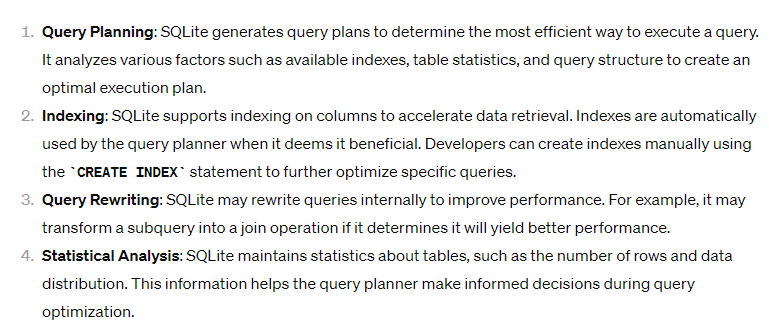

In [ ]:
import sqlite3

# Connect to the SQLite in-memory database
conn = sqlite3.connect(':memory:')

# Create a table
conn.execute('''CREATE TABLE employees (
                    id INTEGER PRIMARY KEY,
                    name TEXT,
                    age INTEGER,
                    department TEXT
                )''')

# Insert some sample data
employees_data = [
    (1, 'Alice', 30, 'HR'),
    (2, 'Bob', 35, 'Engineering'),
    (3, 'Charlie', 28, 'Marketing'),
    # More data here...
]
conn.executemany("INSERT INTO employees (id, name, age, department) VALUES (?, ?, ?, ?)", employees_data)

# Create an index on the department column
conn.execute("CREATE INDEX idx_department ON employees (department)")

# Perform a query
cursor = conn.cursor()
cursor.execute("SELECT * FROM employees WHERE department = 'Engineering' AND age > 30")

# Fetch and print results
results = cursor.fetchall()
print("Results:", results)

# Close the connection
conn.close()

Results: [(2, 'Bob', 35, 'Engineering')]


#Distributed Transactions and Concurrency Control

In [ ]:
# Example of distributed transaction management using SQLite with in-memory databases
# Start transactions on individual nodes and ensure distributed ACID properties

# Connect to the in-memory SQLite databases on different nodes
conn_node1 = sqlite3.connect(':memory:')
conn_node2 = sqlite3.connect(':memory:')

# Start distributed transaction
conn_node1.execute("BEGIN TRANSACTION")
conn_node2.execute("BEGIN TRANSACTION")

# Perform transactional operations on individual nodes
# For example, insert/update/delete records

# Commit transactions on all nodes
conn_node1.execute("COMMIT")
conn_node2.execute("COMMIT")

# Close connections
conn_node1.close()
conn_node2.close()

#MapReduce

In [ ]:
from functools import reduce

# List of documents
documents = [
    "Lorem ipsum dolor sit amet, consectetur adipiscing elit.",
    "Sed do eiusmod tempor incididunt ut labore et dolore magna aliqua.",
    "Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.",
    # More documents here...
]

# Mapper function to split each document into words and emit (word, 1) pairs
def mapper(document):
    words = document.split()
    return [(word.lower(), 1) for word in words]

# Reducer function to aggregate the counts of each word
def reducer(accumulator, pair):
    word, count = pair
    accumulator[word] = accumulator.get(word, 0) + count
    return accumulator

# Map step: Apply the mapper function to each document
mapped_data = map(mapper, documents)

# Reduce step: Combine the mapped data and aggregate the counts
word_counts = reduce(reducer, [pair for sublist in mapped_data for pair in sublist], {})

# Print the word counts
for word, count in word_counts.items():
    print(f"{word}: {count}")

lorem: 1
ipsum: 1
dolor: 1
sit: 1
amet,: 1
consectetur: 1
adipiscing: 1
elit.: 1
sed: 1
do: 1
eiusmod: 1
tempor: 1
incididunt: 1
ut: 3
labore: 1
et: 1
dolore: 1
magna: 1
aliqua.: 1
enim: 1
ad: 1
minim: 1
veniam,: 1
quis: 1
nostrud: 1
exercitation: 1
ullamco: 1
laboris: 1
nisi: 1
aliquip: 1
ex: 1
ea: 1
commodo: 1
consequat.: 1


#NoSQL Databases

#MongoDB

In [ ]:
# Example of using MongoDB with PyMongo
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient('localhost', 27017)

# Access database
db = client['mydatabase']

# Access collection
collection = db['mycollection']

# Perform operations on the collection
# For example, insert documents, query documents, update documents, etc.

# Close connection
client.close()

#Cassandra

In [ ]:
# Example of using Cassandra with cassandra-driver
from cassandra.cluster import Cluster

# Connect to Cassandra
cluster = Cluster(['localhost'])
session = cluster.connect()

# Create keyspace and connect to it
session.execute("CREATE KEYSPACE IF NOT EXISTS mykeyspace WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1}")
session.set_keyspace('mykeyspace')

# Create table
session.execute("CREATE TABLE IF NOT EXISTS mytable (id UUID PRIMARY KEY, name TEXT, age INT)")

# Perform operations on the table
# For example, insert data, query data, etc.

# Close connection
cluster.shutdown()